In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.0.1
annoy                       NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.4
cffi                        1.15.0
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.02.1
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fbpca                       NA
fsspec                      2022.02.0
google                      NA
h5py                        3.6.0
igraph                      0.9.9
intervaltree                NA
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi         

read the Data

In [3]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

  0%|          | 0.00/8.81M [00:00<?, ?B/s]

  0%|          | 0.00/19.6M [00:00<?, ?B/s]

reading C:\Users\Mujtaba Barci\bioimformatic project\data\V1_Mouse_Brain_Sagittal_Anterior\filtered_feature_bc_matrix.h5
 (0:00:01)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


  0%|          | 0.00/9.26M [00:00<?, ?B/s]

  0%|          | 0.00/20.1M [00:00<?, ?B/s]

reading C:\Users\Mujtaba Barci\bioimformatic project\data\V1_Mouse_Brain_Sagittal_Posterior\filtered_feature_bc_matrix.h5
 (0:00:00)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

In [5]:
adata_spatial_posterior

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


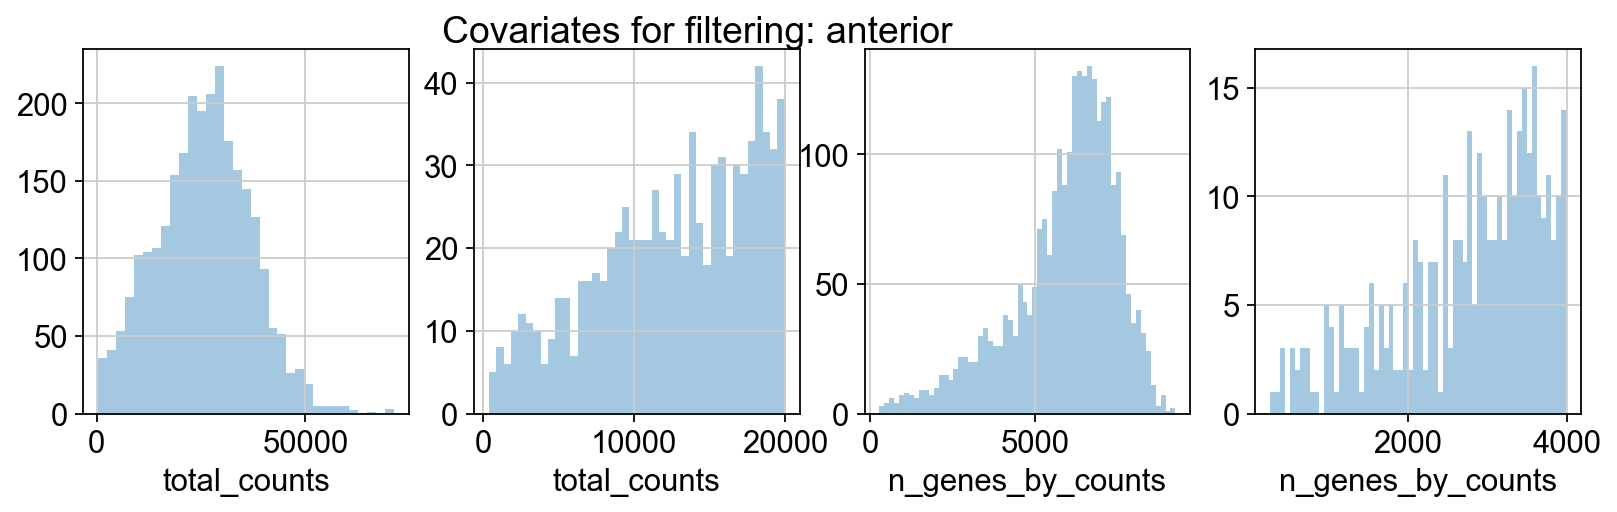

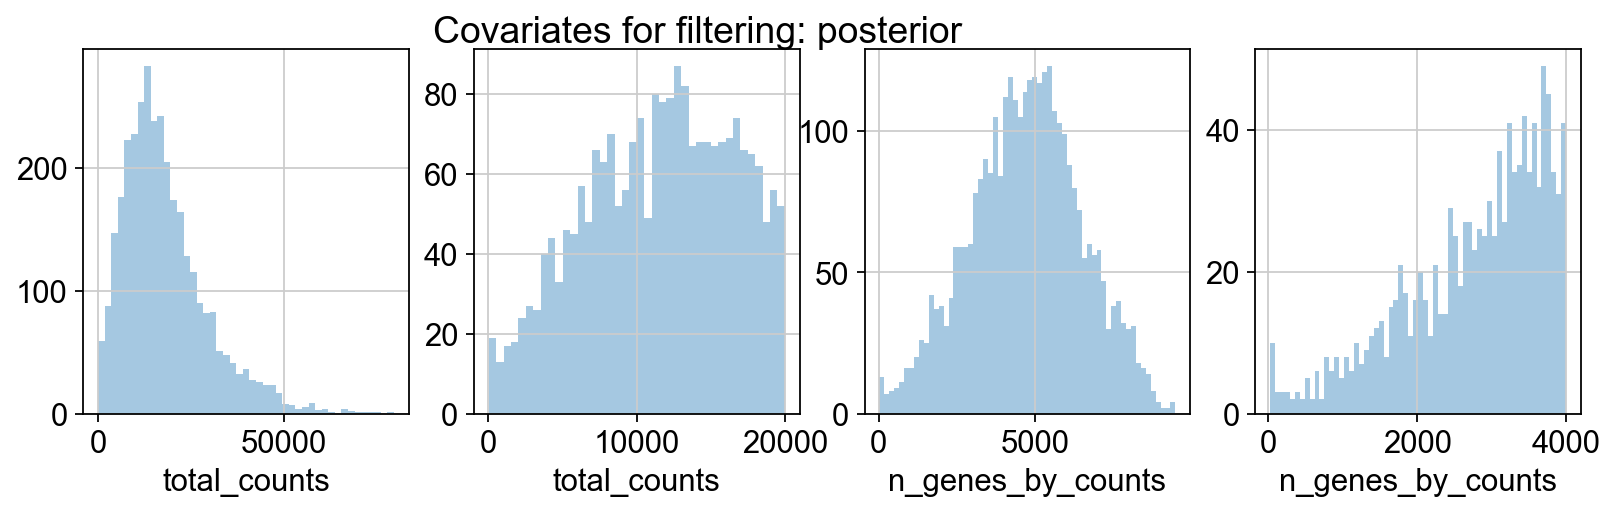

In [6]:
for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [7]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Data integration

In [8]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 32285 genes among all datasets
[[0.         0.48017884]
 [0.         0.        ]]
Processing datasets (0, 1)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanorama\scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])


In [10]:
adata_spatial = sc.concat(
    adatas_cor,
    label="library_id",
    uns_merge="unique",
    keys=[
        k
        for d in [
            adatas_cor[0].uns["spatial"],
            adatas_cor[1].uns["spatial"],
        ]
        for k, v in d.items()
    ],
    index_unique="-",
)

In [11]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 22 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:01)


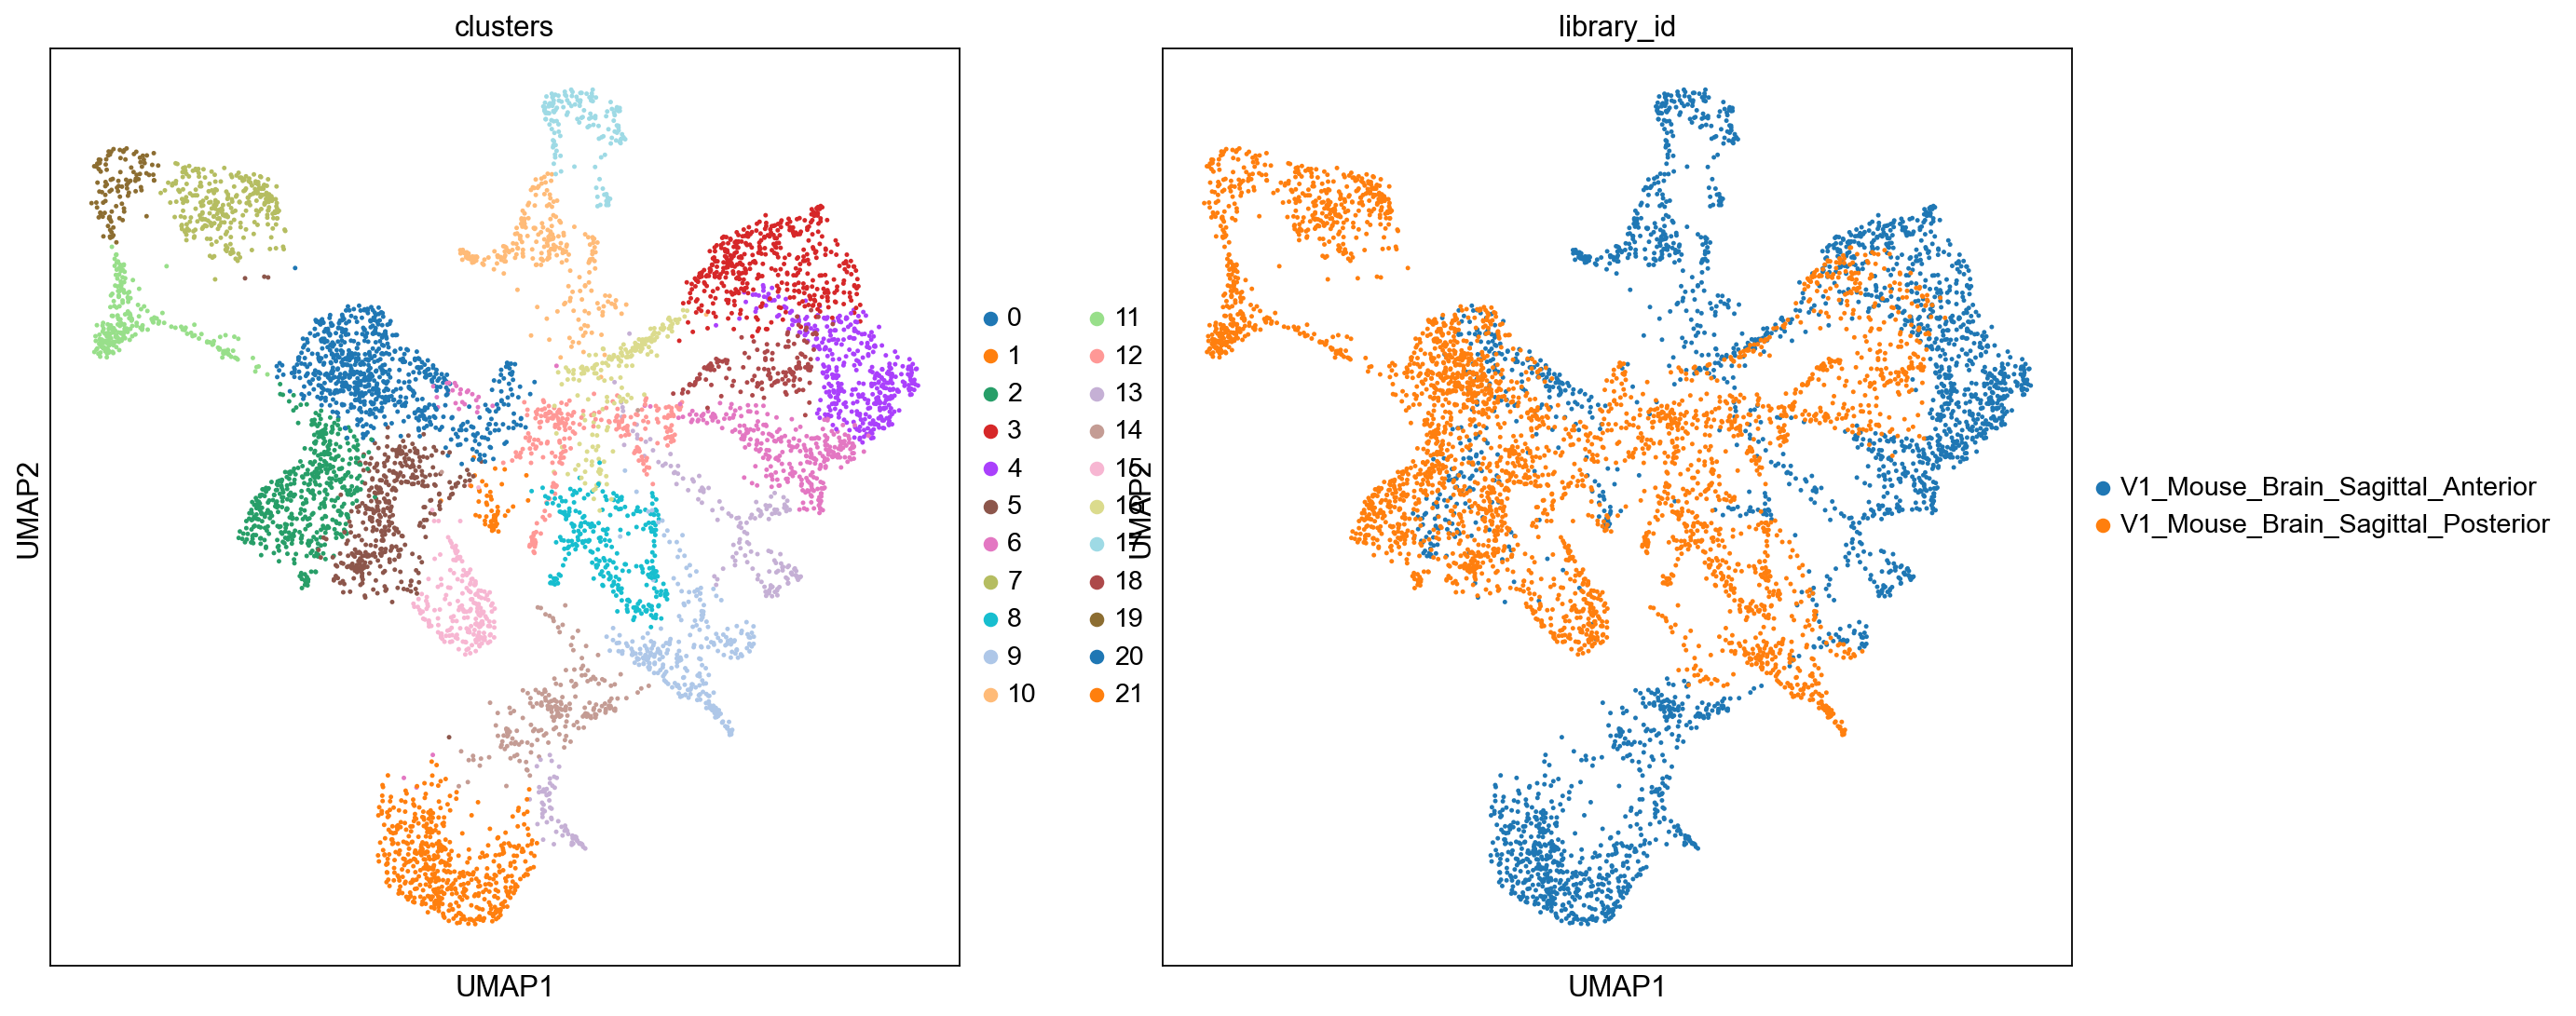

In [17]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

In [18]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)


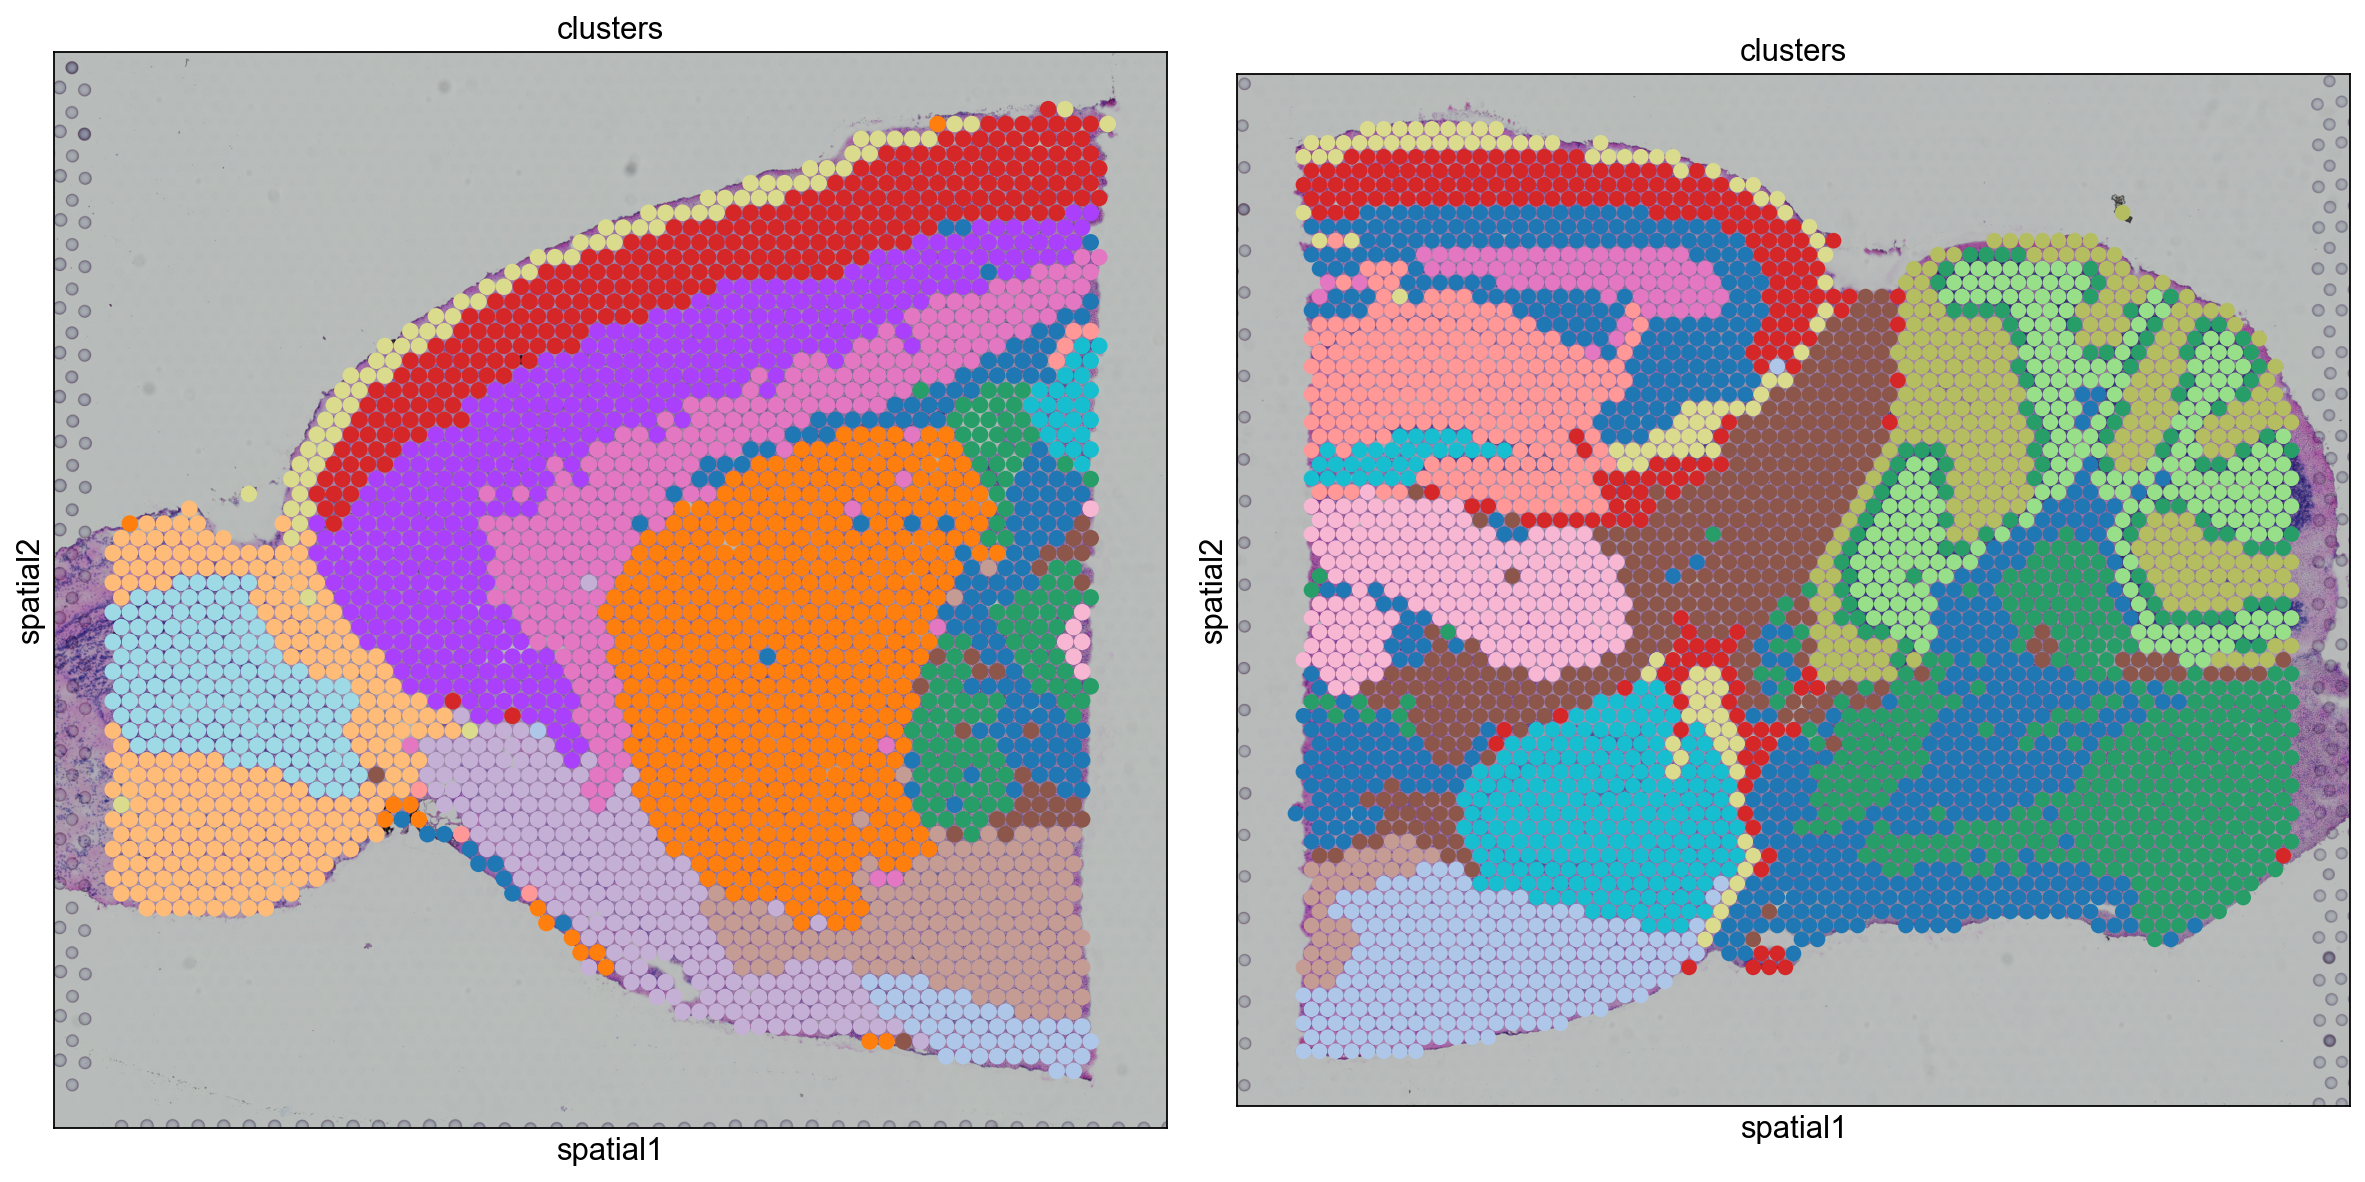

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

From the clusters, we can clearly see the stratification of the cortical layer in both of the tissues (see the Allen brain atlas for reference). Furthermore, it seems that the dataset integration worked well, since there is a clear continuity between clusters in the two tissues.

### Data integration and label transfer from scRNA-seq dataset

 we will transfer cell type labels to the Visium dataset, which were dentified from the scRNA-seq dataset.

For this task, we will be using a dataset from Tasic et al., where the mouse cortex was profiled with smart-seq technology.

In [23]:
adata_cortex = sc.read("./adata_processed.h5ad", backup_url='https://hmgubox.helmholtz-muenchen.de/f/4ef254675e2a41f89835/?dl=1')


try downloading from url
https://hmgubox.helmholtz-muenchen.de/f/4ef254675e2a41f89835/?dl=1
... this may take a while but only happens once


  0%|          | 0.00/3.07G [00:00<?, ?B/s]

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\compat\__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\compat\__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Subset the spatial anndata to (approximately) selects only spots belonging to the cortex.

In [30]:
adata_anterior_subset = adata_spatial_anterior[
    adata_spatial_anterior.obsm["spatial"][:, 1] < 6000, :
]
adata_posterior_subset = adata_spatial_posterior[
    (adata_spatial_posterior.obsm["spatial"][:, 1] < 4000)
    & (adata_spatial_posterior.obsm["spatial"][:, 0] < 6000),
    :,
]

integration with Scanorama

In [31]:


adatas_anterior = [adata_cortex, adata_anterior_subset]
adatas_posterior = [adata_cortex, adata_posterior_subset]


# Integration.
adatas_cor_anterior = scanorama.correct_scanpy(adatas_anterior, return_dimred=True)
adatas_cor_posterior = scanorama.correct_scanpy(adatas_posterior, return_dimred=True)

Found 20538 genes among all datasets
[[0.         0.23395445]
 [0.         0.        ]]
Processing datasets (0, 1)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanorama\scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])


Found 20538 genes among all datasets
[[0.         0.32207207]
 [0.         0.        ]]
Processing datasets (0, 1)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanorama\scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])


Concatenate datasets and assign integrated embeddings to anndata objects.

In [38]:
adata_cortex_anterior = sc.concat(
    adatas_cor_anterior,
    label="dataset",
    keys=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)
adata_cortex_posterior = sc.concat(
    adatas_cor_posterior,
    label="dataset",
    keys=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)

compute cosine distances between the visium dataset and the scRNA-seq dataset, in the common embedding space

In [39]:
from sklearn.metrics.pairwise import cosine_distances

distances_anterior = 1 - cosine_distances(
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "smart-seq"].obsm[
        "X_scanorama"
    ],
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "visium"].obsm[
        "X_scanorama"
    ],
)
distances_posterior = 1 - cosine_distances(
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "smart-seq"].obsm[
        "X_scanorama"
    ],
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "visium"].obsm[
        "X_scanorama"
    ],
)

propagate labels from the scRNA-seq dataset to the visium dataset



In [45]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

In [47]:
class_prob_anterior = label_transfer(distances_anterior, adata_cortex.obs.cell_subclass)
class_prob_posterior = label_transfer(
    distances_posterior, adata_cortex.obs.cell_subclass
)

convert the class_prob_[anterior-posterior] object to a dataframe and assign it to the respective anndata

In [48]:
cp_anterior_df = pd.DataFrame(
    class_prob_anterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)
cp_posterior_df = pd.DataFrame(
    class_prob_posterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)

cp_anterior_df.index = adata_anterior_subset.obs.index
cp_posterior_df.index = adata_posterior_subset.obs.index


In [49]:
adata_anterior_subset_transfer = adata_anterior_subset.copy()
adata_anterior_subset_transfer.obs = pd.concat(
    [adata_anterior_subset.obs, cp_anterior_df], axis=1
)

adata_posterior_subset_transfer = adata_posterior_subset.copy()
adata_posterior_subset_transfer.obs = pd.concat(
    [adata_posterior_subset.obs, cp_posterior_df], axis=1
)

cell types are propagated from the scRNA-seq dataset to the visium dataset, first visualize the neurons cortical layers.



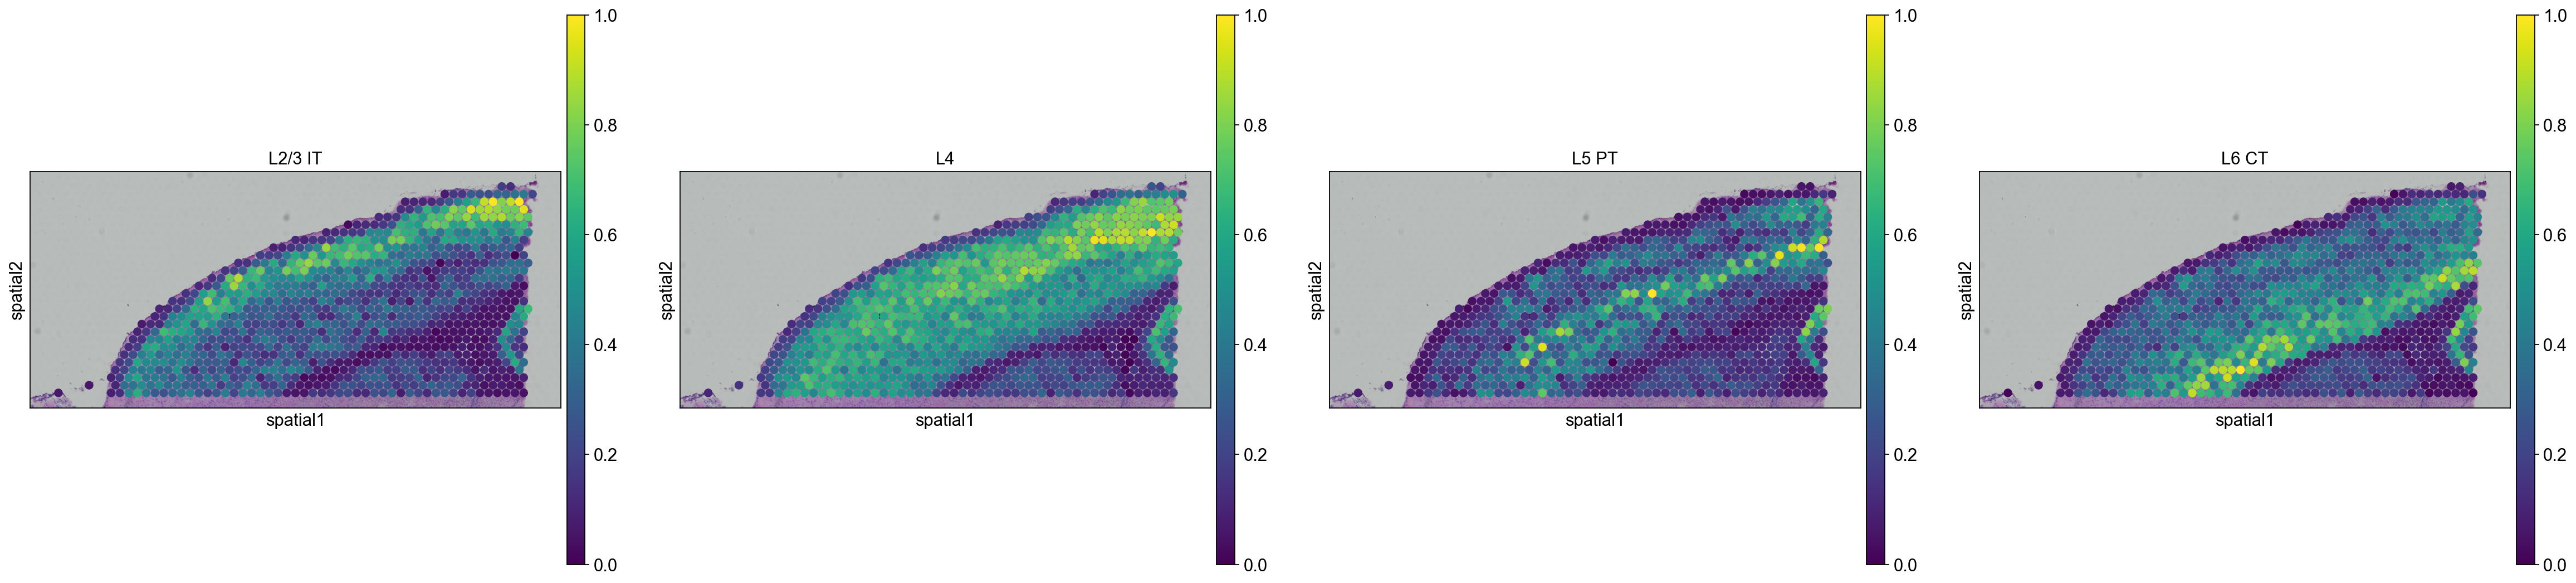

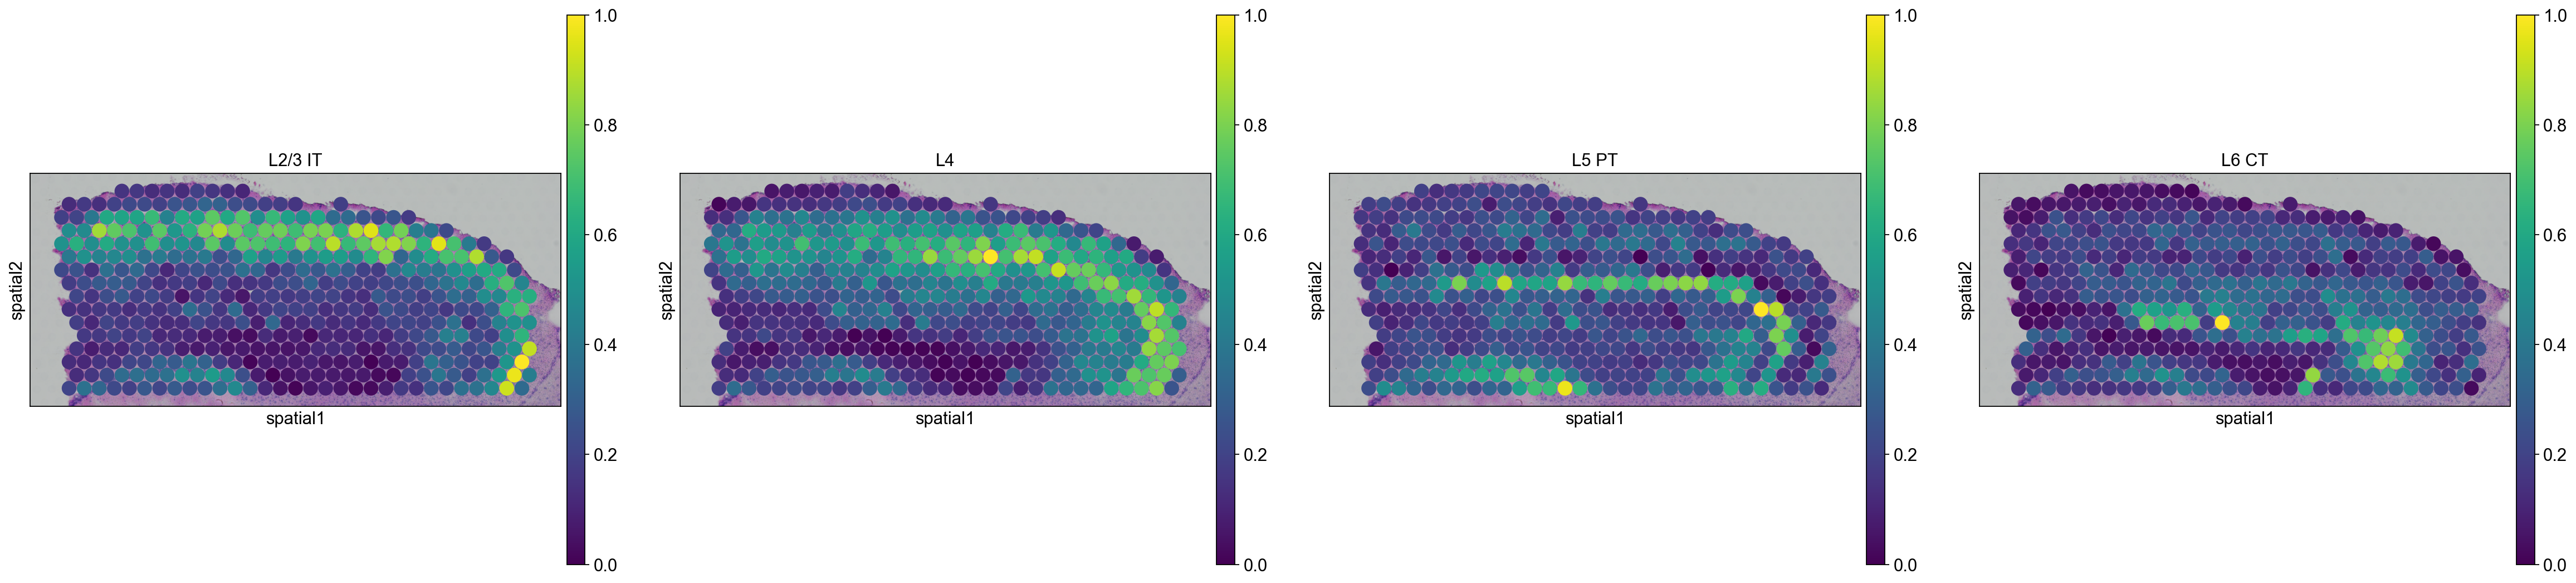

In [52]:
sc.pl.spatial(
    adata_anterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)
sc.pl.spatial(
    adata_posterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)

since sequential layers of cortical neurons could be correctly identified, both in the anterior and posterior sagittal slide.

visualize astrocytes and oligodendrocytes as well.



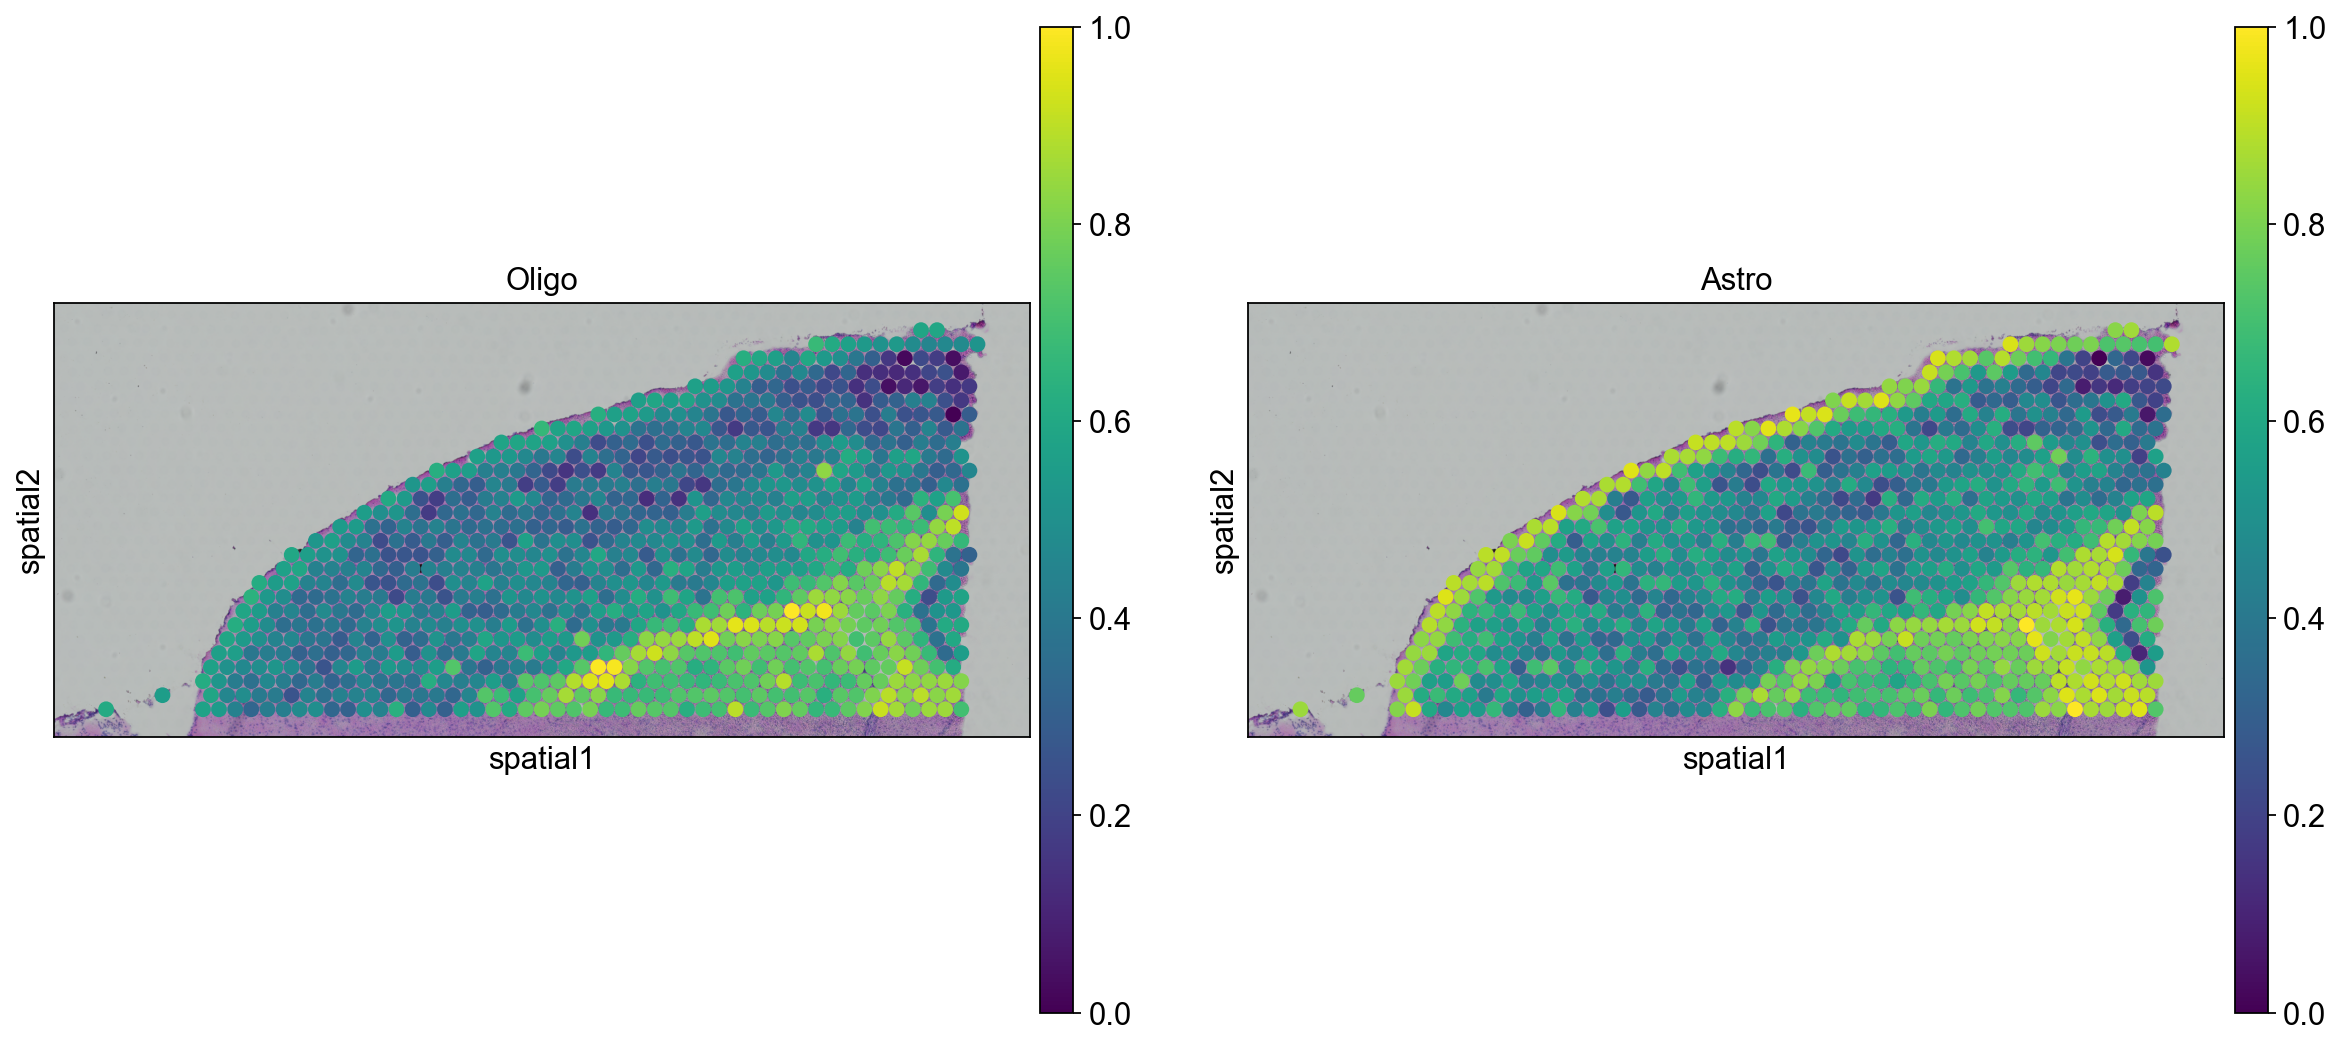

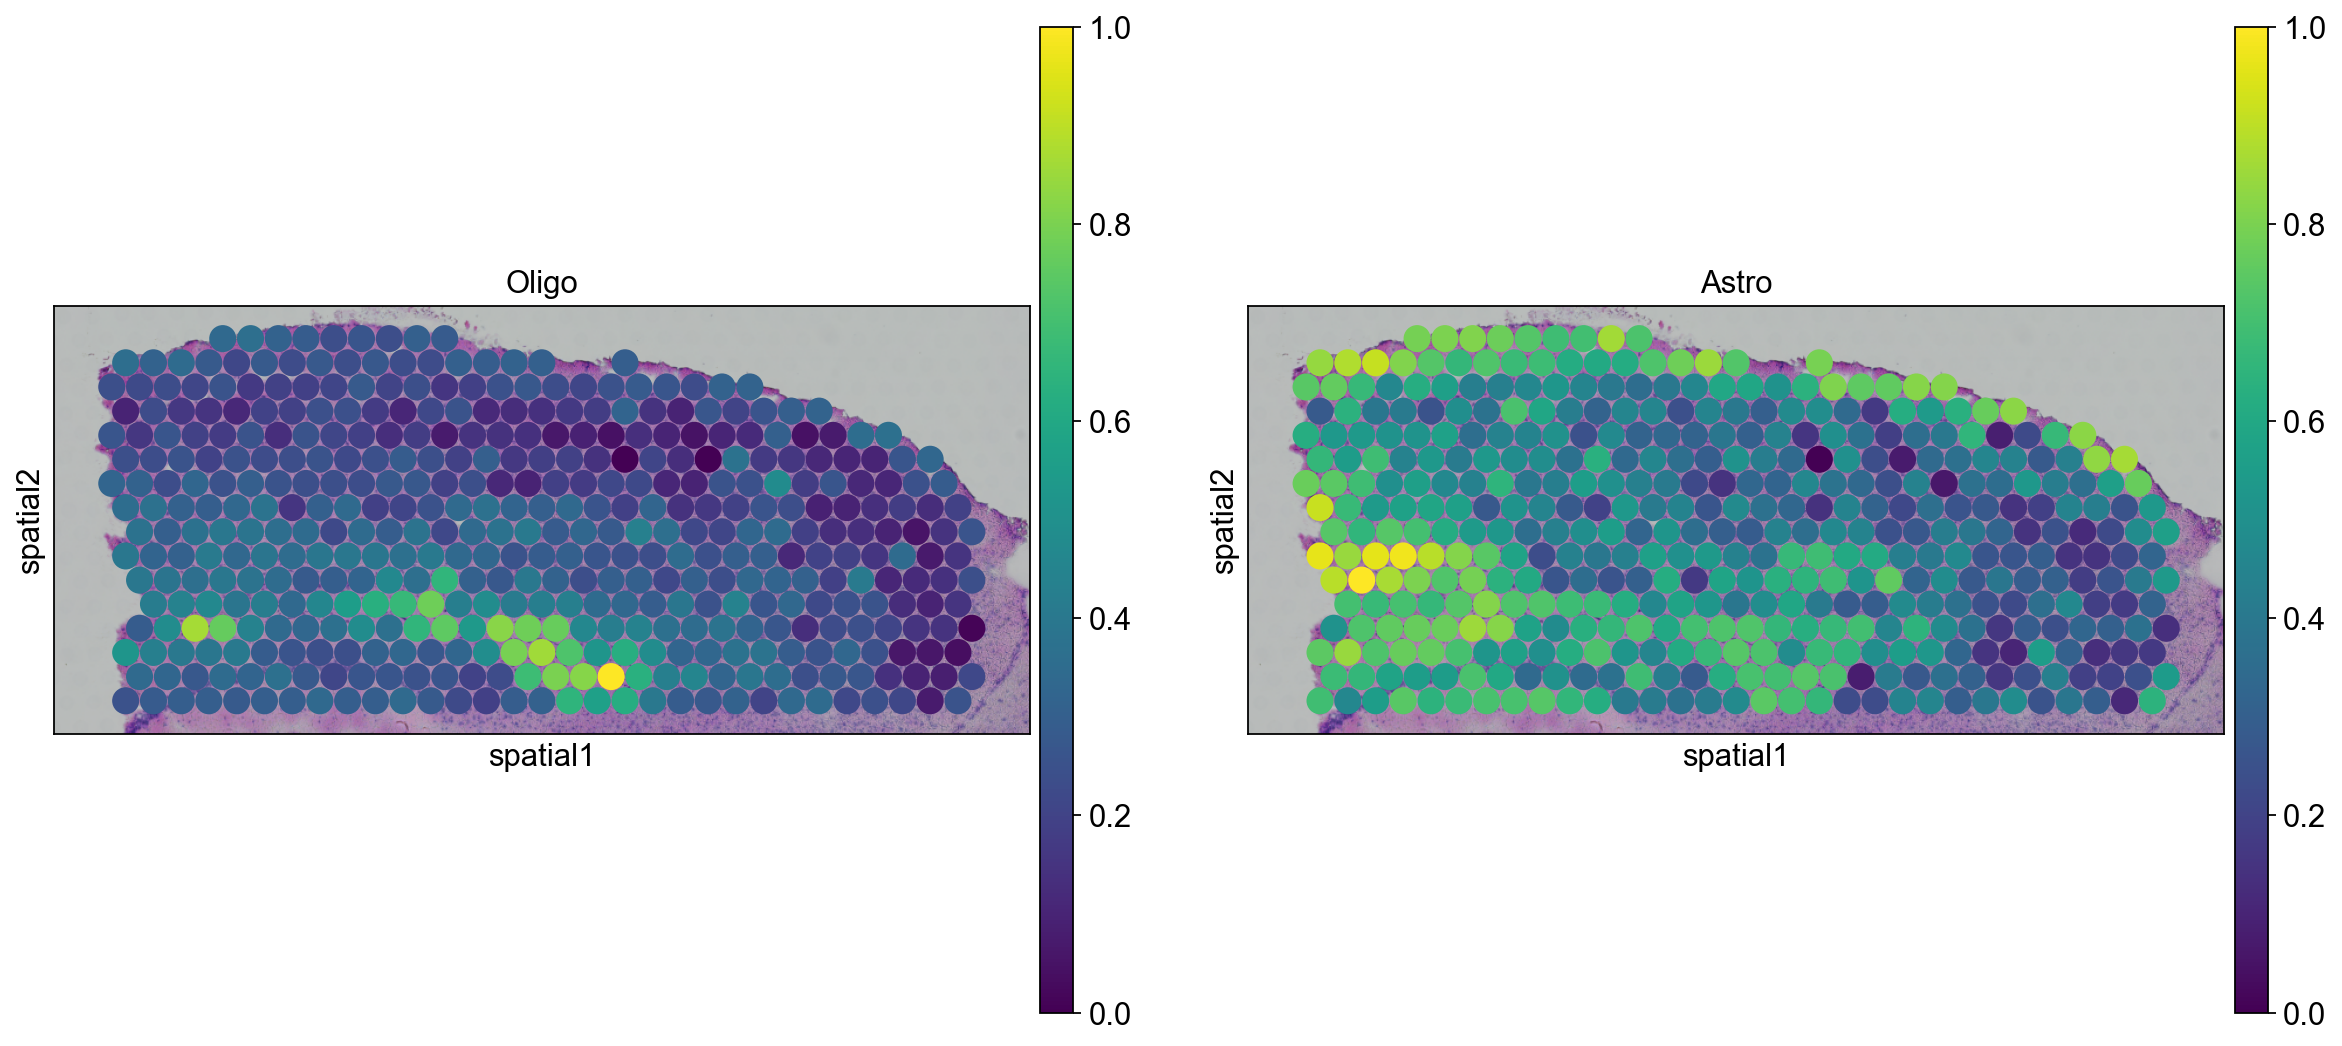

In [53]:
sc.pl.spatial(
    adata_anterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)
sc.pl.spatial(
    adata_posterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)

In [54]:
   adata_anterior_subset_transfer

AnnData object with n_obs × n_vars = 966 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Astro', 'CR', 'Endo', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Macrophage', 'Meis2', 'NP', 'No Class', 'Oligo', 'Peri', 'Pvalb', 'SMC', 'Serpinf1', 'Sncg', 'Sst', 'VLMC', 'Vip', 'nan'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'